In [33]:
import sys
import pyccl as ccl
import numpy as np
from clmm import Cosmology
from multiprocessing import Pool
import emcee
import matplotlib.pyplot as plt
from itertools import combinations, chain
import time
import healpy
import pickle
import analysis_list
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/cluster_abundance')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_COUNT_class_likelihood as likelihood
import CL_LENSING_cluster_lensing as cl_lensing
CLCount_likelihood = likelihood.Likelihood()

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import analysis_Mass_Richness_relation as analysis

table_redmapper = load('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/richness_mass_from_DC2/catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl')
N_obs, proxy_edges, z_edges = np.histogram2d(table_redmapper['redshift'], 
                                                        table_redmapper['richness'],
                                                   bins=[analysis.z_corner, analysis.rich_corner])

In [89]:
n = len(table_redmapper)/440

In [116]:
n_hp = n*healpy.nside2pixarea(8, degrees=True)

In [117]:
n_hp

5503.4468101475795

In [118]:
healpy.nside2pixarea(2**8, degrees=True)

0.052455852825697924

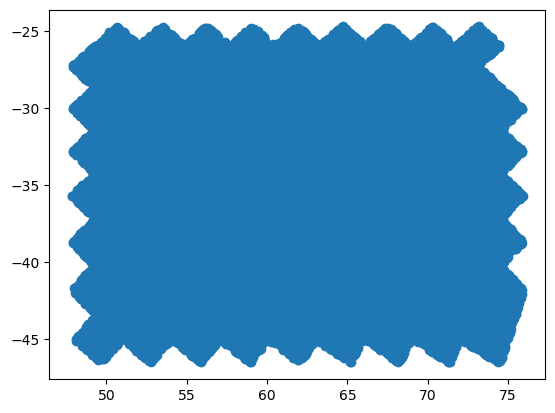

In [119]:
plt.scatter(table_redmapper['ra'], table_redmapper['dec'])

In [123]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

def compute_jackknife_covariance_healpy(catalog = None, 
                                            proxy_colname = 'mass', redshift_colname = 'redshift',
                                            z_corner = None, proxy_corner = None, 
                                            ra_colname = 'ra', dec_colname = 'dec', 
                                            n_side = 4096, N_delete = 1):
        r"""
        Attributes:
        -----------
        proxy_colname: str
            name of the proxy column
        redshift_colname: str
            name of the redshift column
        proxy_corner: str
            values of proxues to be binned
        ra_colname: str
            name of the ra column
        dec_colname: str
            name of the dec column
        z_corner: str
            values of redshifts to be binned
        n_power: int
            defines the number of healpix pixels
        N_delete: int
            number of jackknife region to delete each repetition
        Returns:
        --------
        cov_N: array
            Jackknife covariance matrix
        """
        proxy, redshift = np.array(catalog[proxy_colname]), np.array(catalog[redshift_colname])
        ra, dec =  np.array(catalog[ra_colname]), np.array(catalog[dec_colname])
        index = np.arange(len(proxy))
        healpix = healpy.ang2pix(n_side, ra, dec, nest=True, lonlat=True)
        healpix_list_unique = np.unique(healpix)

        n_density = []
        for h in healpix_list_unique:
            n_density.append(len(healpix[healpix==h]))
       #print(n_density)
        mask = np.array(n_density)>5000
        weights = n_density/n_hp
        print(f'Number of JK regions: {len(healpix_list_unique)}')
        healpix_combination_delete = list(combinations(healpix_list_unique[mask], N_delete))
        data_jack = []
        for i, hp_list_delete in enumerate(healpix_combination_delete):
            print(hp_list_delete)
            if (i/2000.).is_integer():
                print(i)
            mask_in_area = np.isin(healpix, hp_list_delete)
            mask_out_area = np.invert(mask_in_area)
            #data, mass_edges, z_edges = np.histogram2d(redshift[mask_out_area], 
            #                                           proxy[mask_out_area],
            #                                           bins=[z_corner, proxy_corner]) 
            data, mass_edges, z_edges = np.histogram2d(redshift[mask_out_area],
                                                       proxy[mask_out_area],
                                                       bins=[z_corner, proxy_corner,])
            data_jack.append(data.flatten())
        data_jack = np.array(data_jack)
        N = np.stack((data_jack.astype(float)), axis = 1)
        n_jack = len(healpix_combination_delete)
        cov_N = (n_jack - 1) * np.cov(N, bias = False,ddof=0)
        coeff = (n_jack-N_delete)/(N_delete*n_jack)
        Jackknife_covariance_matrix = cov_N * coeff
        
        return Jackknife_covariance_matrix

In [124]:
res = compute_jackknife_covariance_healpy(catalog = table_redmapper, 
                                            proxy_colname = 'richness', redshift_colname = 'redshift',
                                            z_corner = analysis.z_corner, proxy_corner = analysis.rich_corner, 
                                            ra_colname = 'ra', dec_colname = 'dec', 
                                            n_side = 8, N_delete = 1)

Number of JK regions: 14
(537,)
0
(539,)
(540,)
(542,)


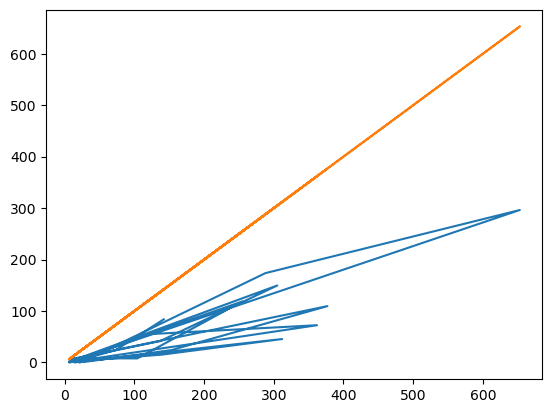

In [125]:
plt.plot(N_obs.flatten(), res.diagonal())
plt.plot(N_obs.flatten(), N_obs.flatten())